# Generative Adversarial Network

In this blog, we'll be building a **generative adversarial network (GAN)** trained on the MNIST(Handwritten Digit) dataset. From this, we'll be able to generate new handwritten digits. GAN's were introduced by **Ian Goodfellow** et al. in 2014. Since then, GANs have exploded in popularity.  This technique can generate photographs that look at least superficially authentic to human observers, having many realistic characteristics.

In Machine Learning, GANs are a class of **artificial intelligence algorithms** used in unsupervised machine learning. 
The idea behind GANs is that you have two networks, a `generator  G`, and a `discriminator  D`, competing with each other in a **zero-sum game framework**. 

The generator makes fake data to pass to the discriminator, technically generative network learns to map from a `latent space z` to a particular `data distribution of interest`,  The discriminator also sees real data and predicts if the data it's received is `real` or `fake` by discriminates between instances from the `real data distribution` and `candidates produced by the generator`. 

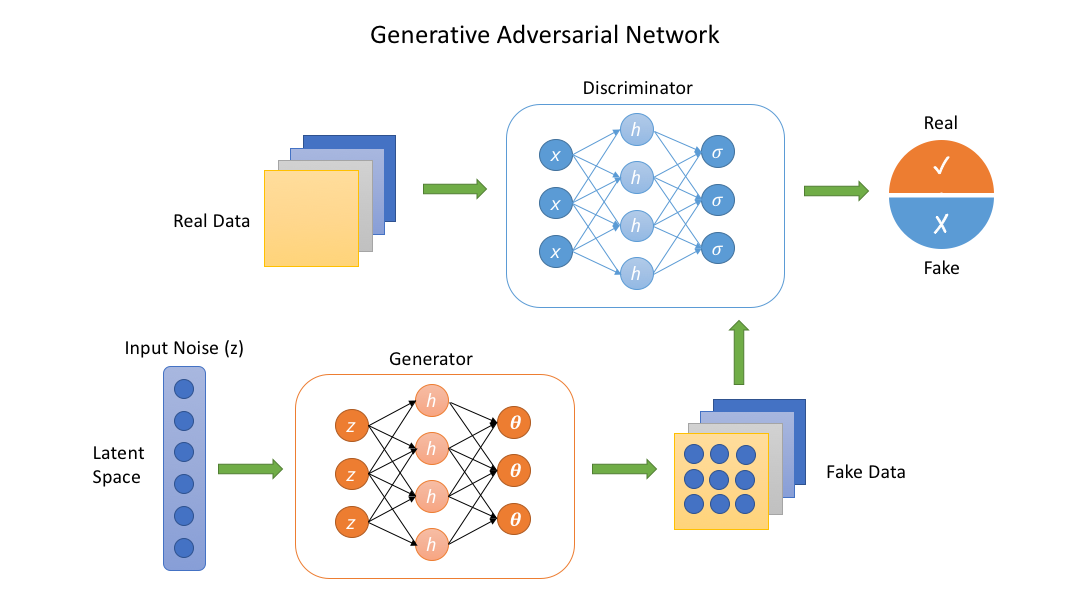

The **generator is trained to fool the discriminator**, and it wants to output data that looks as close as possible to real data, by producing novel synthesized instances that appear to have come from the real data distribution. Moreover, the **discriminator is trained** to figure out which **data is real** and which **is fake**. What ends up happening is that the generator learns to **make data** that is **indistinguishable** from real data to the discriminator.

`Backpropagation` is applied in both networks so that the generator produces better images, while the discriminator becomes more skilled at flagging synthetic images. The generator is typically a deconvolutional neural network, and the discriminator is a convolutional neural network.



## Import Data and Libraries

In [1]:
# Import tensorflow, numpy for random sample creation and pickle for saving results
import tensorflow as tf
import numpy as np
import pickle as pkl

In [2]:
# Import matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib notebook

In [4]:
# Download MNIST dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./data/",one_hot=True)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


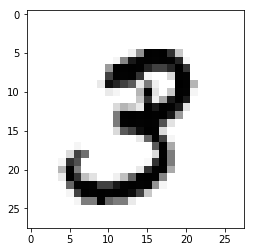

In [5]:
# Plot any random sample
plt.imshow(mnist.train.images[1].reshape(28,28),cmap='Greys');

## Model Inputs

First we need to create the inputs for our tensorflow graph. We need two inputs, one for the **generator** and one for the **discriminator**. Here we'll call the generator input `inputs_z` and the discriminator input `inputs_real`.

In [6]:
# function to create placeholder for input data
def model_inputs(real_dim, z_dim):
    
    # placeholder for real data
    inputs_real = tf.placeholder(tf.float32,shape=[None,real_dim])
    
    # placeholder for latent space
    inputs_z = tf.placeholder(tf.float32,shape=[None,z_dim])
    
    return(inputs_real, inputs_z)

## Generator

The input to the generator is a series of randomly generated numbers called `latent space` (**Latent variables** are variables that are not directly observed but are rather inferred through a **mathematical model** from other variables that are observed).

The generator is **neural network** which contains a hidden layer with `Leaky ReLU` activation and `tanh` output. It tries to map latent space to real dataset images using the backpropagation algorithm. Once trained, the generator can produce digit images from latent samples. 

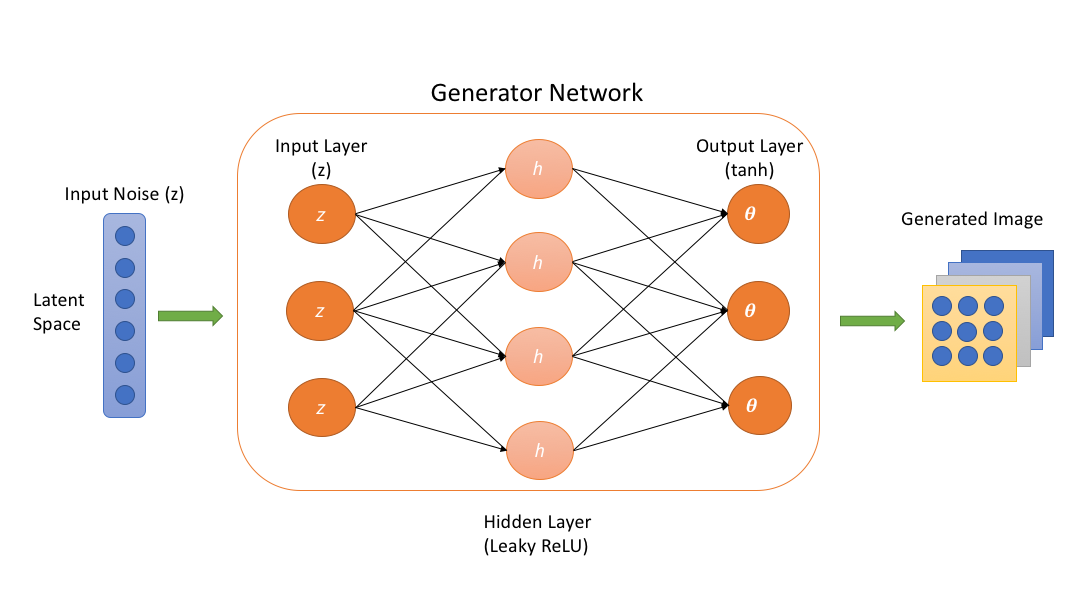

In [7]:
# function to create generator
def generator(z, out_dim, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('generator', reuse=reuse):
        
        # Hidden layer
        hidden1 = tf.layers.dense(z, n_units, activation=None)
        
        # Leaky ReLU
        hidden1 = tf.maximum(alpha * hidden1, hidden1)

        # Logits and tanh output
        logits = tf.layers.dense(hidden1, out_dim, activation=None)
        output = tf.tanh(logits)
        
        return(output)

## Discriminator

The discriminator is a **classifier** trained using the **supervised learning**. It classifies whether an image is `real (1)` or `Fake (0)`. We train the discriminator using both the **real dataset images** and the **images generated by the generator**. 

If the input image is from the MNIST dataset, the discriminator should classify it as `real`. If the input image is from the generator, the discriminator should classify it as` fake`. The discriminator network is almost the same as the generator network, except that we're using a `sigmoid` output layer.

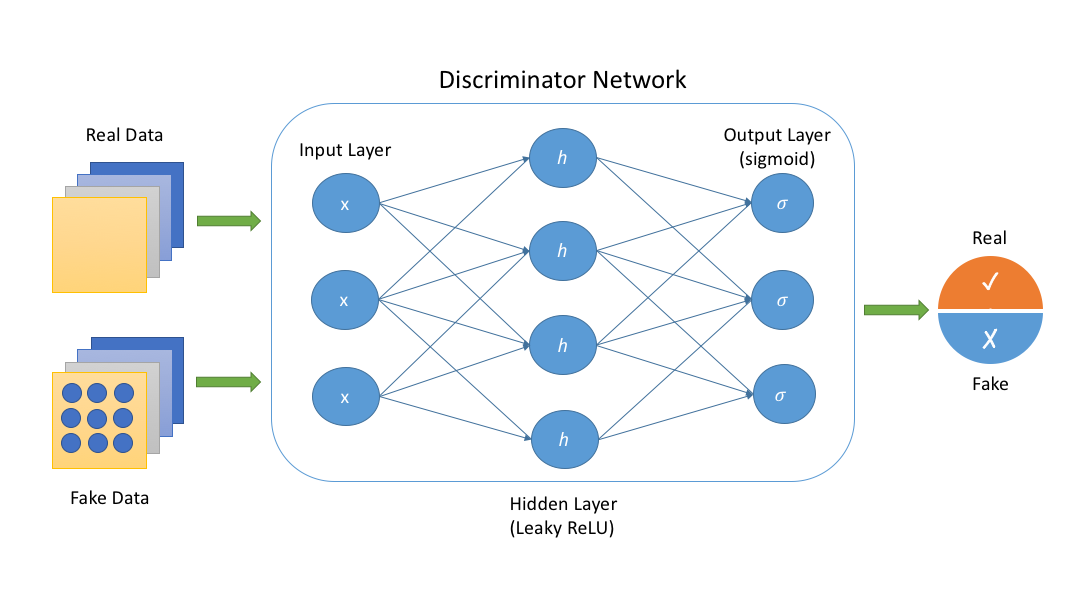

In [8]:
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Hidden layer
        hidden1 = tf.layers.dense(x, n_units, activation=None)
        
        # Leaky ReLU
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        
        # Logits and sigmoid output
        logits = tf.layers.dense(hidden1, 1, activation=None)
        output = tf.sigmoid(logits)
        
        return(output, logits)

## Hyperparameters

In [9]:
# Size of input image to discriminator
input_size = 784
# Size of latent vector to generator
z_size = 100

# Sizes of hidden layers in generator and discriminator
g_hidden_size = 128
d_hidden_size = 128

# Leak factor for leaky ReLU and Smoothing 
alpha = 0.01
smooth = 0.1

## Define Network

To building the network from the functions defined above we connect the **generator** and the **discriminator** to produce a GAN.

* First is to get our inputs, `input_real, input_z` from `model_inputs` using the sizes of the input and z.

* Then, we'll create the generator. This builds the generator with the appropriate `input` and `output` sizes.

* Then the discriminators. We'll build two of them, one for `real data` and one for `fake data`.

We will set `reuse=True`, since we want the **weights** to be the **same** for both `real` and `fake` data, we need to reuse the variables.

In [10]:
tf.reset_default_graph()
# Create our input placeholders
input_real, input_z = model_inputs(input_size, z_size)

# Build the generator model
g_model = generator(input_z, input_size, n_units=g_hidden_size, alpha=alpha)

# Build the two discriminator model 'one for real images and one for generator images' and update common weights
d_model_real, d_logits_real = discriminator(input_real, n_units=d_hidden_size, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, n_units=d_hidden_size, alpha=alpha)

## Define Losses

Now we need to calculate the losses for both generator and discriminator, which is a little tricky. 

In **discriminator**, the total loss is the sum of the losses for **real** and **fake** images.

``` d_loss = d_loss_real + d_loss_fake ```

* For the real image logits, `d_logits_real` and the `labels`, we want them to be all `ones`, since these are all real images. To help the discriminator generalize better, the labels are reduced a bit from 1.0 to 0.9.

* For the fake data is similar, the logits are `d_logits_fake`, these fake logits are used with `labels` of all `zeros`. 

Finally, the **generator** losses are using `d_logits_fake`, the fake image logits. But, now the `labels` are all `ones`. The generator is trying to fool the discriminator, so it wants to discriminator to output ones for fake images.

In [11]:
def loss_func(logits_in,labels_in):
    return(tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in,labels=labels_in)))

In [12]:
# discriminator loss for fake and real images
d_loss_real = loss_func(d_logits_real, tf.ones_like(d_logits_real) * (1 - smooth))
d_loss_fake = loss_func(d_logits_fake, tf.zeros_like(d_logits_fake))

# total discriminator loss
d_loss = d_loss_real + d_loss_fake

In [13]:
# generator loss
g_loss = loss_func(d_logits_fake, tf.ones_like(d_logits_fake))

## Optimizers

We are going to create two **optimizer**, one for **generator** and one for **discriminator**. To update the generator and discriminator variables separately, we need need list of variable specific to the optimizer. To get all the **trainable variables**, we use `tf.trainable_variables()`. 

We have used **variable scope** to start all of our generator variable names with `generator`, and all the variables in the discriminator start with `discriminator`. Now, we just need to iterate through the list from `tf.trainable_variables()` and keep variables to start with `generator` in `g_vars` and `discriminator` in `d_vars`. 

In [14]:
# Get all the trainable_variables, and split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

In [15]:
# Learning Rate
learning_rate = 0.002

# Optimizers
d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

## Network Training

In [16]:
batch_size = 100
epochs = 500
losses = []

In [17]:
# Only save generator variables
saver = tf.train.Saver(var_list=g_vars)

# initialize session
with tf.Session() as sess:
    
    # initialize global variable
    sess.run(tf.global_variables_initializer())
    
    for e in range(epochs):
        
        # train the model 
        for i in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
            
        print("Epoch {}/{} - DLoss: {:.4f} - GLoss: {:.4f} \r".format(e+1,epochs,train_loss_d,train_loss_g),end='')  
        
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        # Save sess checkpoint
        saver.save(sess, './checkpoints/generator.ckpt')

In [18]:
# Save training losses after each epoch
with open('train_losses.pkl', 'wb') as f:
    pkl.dump(losses, f)

## Training Loss Visualization

In training we have created a list of losses for `generator` and `discriminator` to  check how well our GAN is trained. Now we can visualize using `train_losses.pkl`.

In [17]:
# Load samples from generator taken while training
with open('train_losses.pkl', 'rb') as f:
    losses = pkl.load(f)

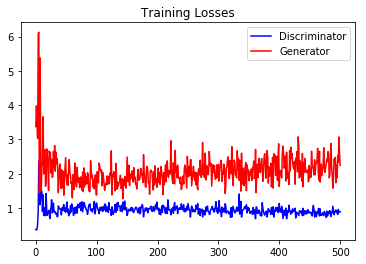

In [18]:
# visualize losses for generator and discriminator
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator',c='b')
plt.plot(losses.T[1], label='Generator',c='r')
plt.title("Training Losses")
plt.legend();

## Generate New Sample

To generate new sample we are going to `load` the saved module, `initialize` our session and `pass random noise` to the generater. 

INFO:tensorflow:Restoring parameters from checkpoints/generator.ckpt


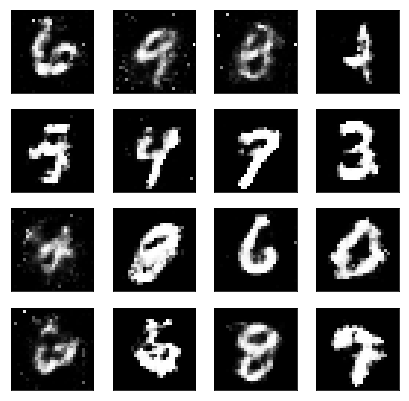

In [21]:
# load the generator variables
saver = tf.train.Saver(var_list=g_vars)

# initialize session
with tf.Session() as sess:
    
    # restor the checkpoints
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # create random noise for the generator
    sample_z = np.random.uniform(-1, 1, size=(16, z_size))
    
    # generate new sample
    gen_samples = sess.run(generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                           feed_dict={input_z: sample_z})
    
    # plot the result
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), gen_samples):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

## Conclusion

I hope that in this blog, you have understood the underlying architecture of a new technique called Generative Adversarial Networks. GANs are one of the few successful and efficient techniques in unsupervised machine learning. GANs have been successfully applied in many fields including music generator,  interactive image editing, 3D shape estimation, drug discovery, create books which seem written by authentic authors and much more. Some of the success stories include.

* Adobe Research is using GAN for designing products, generating novel imagery from scratch based on users' scribbles.

* Facebook has built a real-time style transfer model running on mobile devices. 